# 优化器

In [1]:
import torch as t
from torch import nn
from torch.autograd import Variable as V

# 首先定义一个 LeNet 网络


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 6, 5), 
                                      nn.ReLU(),
                                      nn.MaxPool2d(2, 2), 
                                      nn.Conv2d(6, 16, 5),
                                      nn.ReLU(), 
                                      nn.MaxPool2d(2, 2))
        self.classifier = nn.Sequential(nn.Linear(16 * 5 * 5, 120), 
                                        nn.ReLU(),
                                        nn.Linear(120, 84), 
                                        nn.ReLU(),
                                        nn.Linear(84, 10))

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x


net = Net()


In [2]:
from torch import optim

optimizer = optim.SGD(params=net.parameters(), lr=1)
optimizer.zero_grad()  # 梯度清零，等价于 net.zero_grad()

inp = V(t.randn(1, 3, 32, 32))
output = net(inp)
output.backward(output)

optimizer.step()  # 优化参数

nn.Sequential
> 一个有序的容器，神经网络模块将按照在传入构造器的顺序依次被添加到计算图中执行，同时以神经网络模块为元素的有序字典也可以作为传入参数

In [ ]:
# Example of using Sequential
        model = nn.Sequential(
                  nn.Conv2d(1,20,5),
                  nn.ReLU(),
                  nn.Conv2d(20,64,5),
                  nn.ReLU()
                )

        # Example of using Sequential with OrderedDict
        model = nn.Sequential(OrderedDict([
                  ('conv1', nn.Conv2d(1,20,5)),
                  ('relu1', nn.ReLU()),
                  ('conv2', nn.Conv2d(20,64,5)),
                  ('relu2', nn.ReLU())
                ]))

## 针对不同的网络设定不同的 lr

In [3]:
# 为不同子网络设置不同的学习率，在 finetune 中经常用到
# 如果对某个参数不指定学习率，就使用默认学习率
ptimizer = optim.SGD(
    [
        {
            'params': net.features.parameters()
        },  # 学习率为 1e-5
        {
            'params': net.classifier.parameters(),
            'lr': 1e-2
        }
    ],
    lr=1e-5)

## 针对不同的层设定不同的 lr

In [ ]:
# 只为两个全连接层设置较大的学习率，其余层的学习率较小
special_layers = nn.ModuleList([net.classifier[0], net.classifier[3]])
special_layers_params = list(map(id, special_layers.parameters()))  # 得到特殊层的 id

# 筛选出不属于特殊层的层
base_params = filter(lambda p: id(p) not in special_layers_params,
                     net.parameters())

# 对于特殊层和非特殊层设定不同的 lr
optimizer = t.optim.SGD([{
    'params': base_params
}, {
    'params': special_layers.parameters(),
    'lr': 0.01
}],
                        lr=0.001)


## 动态修改 lr
在跑代码的过程中，我们可能需要中途改变学习率的大小。在 torch 中提供了两种做法：
1. 直接修改 optimizer.parm_groups 中对应的学习率（不推荐）
2. 由于 optimizer 十分轻量级，开销很小，因此可以新建优化器（推荐）

如果使用第二种方法新建一个优化器，在这个过程中新建的优化器会初始化动量等状态信息，这对使用动量的优化器来说（如自带 momentum 的 sgd），可能会造成损失函数在收敛过程中震荡。

In [4]:
# 调整学习率，新建一个 optimizer
old_lr = 0.1

optimizer = optim.SGD([{
    'params': net.features.parameters()
}, {
    'params': net.classifier.parameters(),
    'lr': old_lr * 0.1
}],
                      lr=1e-5)


# nn.functional
**如果有可学习的参数时，最好用 Module，反之既可以用 functional，当然也可以用 Module，因为二者在性能上并没有很大的差别。**

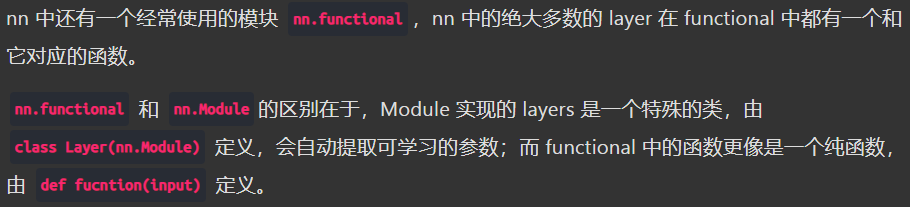

In [6]:
import torch as t
from torch import nn
from torch.autograd import Variable as V
inp = V(t.randn(2, 3))
model = nn.Linear(3, 4)
output1 = model(inp)
output2 = nn.functional.linear(inp, model.weight, model.bias)
output1 == output2


tensor([[True, True, True, True],
        [True, True, True, True]])

In [7]:
b = nn.functional.relu(inp)
b2 = nn.ReLU()(inp)
b == b2


tensor([[True, True, True],
        [True, True, True]])

## nn.functional 和 nn.Module 结合使用

In [ ]:
from torch.nn import functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.pool(F.relu(self.conv1(x)), 2)
        x = F.pool(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

**较于Module而言，Functional更加麻烦，需要自己手动定义参数**

In [8]:
#从代码的对比中可以看出，如果通过 functional 去构造一个具有可学习参数的层，
# 是非常麻烦的，不如 Module 那样简便
class MyLinear(nn.Module):
    def __init__(self):
        super(MyLinear, sefl).__init__()
        self.weight = nn.Parameter(t.randn(3, 4))
        self.bias = nn.Parameter(t.zeros(3))

    def forward(self):
        return F.linear(input, weight, bias)

# 参数初始化策略

## 利用 nn.init 初始化

In [ ]:
import torch as t
from torch import nn
from torch.nn import init
linear = nn.Linear(3, 4)

t.manual_seed(1)
# 等价于 linear.weight.data.normal_(0, std)
init.xavier_normal_(linear.weight)  #

## 直接初始化

In [ ]:
import math
t.manual_seed(1)

# xavier初始化的计算公式
std = math.sqrt(2) / math.sqrt(7.)
linear.weight.data.normal_(0, std)

# 对模型的所有参数进行初始化
for name, params in net.named_parameters():
    if name.find('linear') != -1:  # 对所有全连接层的参数进行初始化
        # init linear
        params[0]  # weight
        params[1]  # bias
    elif name.find('conv') != -1:
        pass
    elif name.find('norm') != -1:
        pass
